In [1]:
%reset -f

In [2]:
import numpy as np
import torchdiffeq
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from typing import List

In [3]:
torch.cuda.empty_cache()

In [4]:
# --- build a simple rod: 3 DOF per node (x,y,z) ---
def create_rod_with_nodes(num_nodes: int):
    nodes = []
    for i in range(num_nodes):
        nodes.append(np.array([i * 0.1, 0.0, 0.0], dtype=np.float32))
    return nodes
num_nodes = 11
nodes = create_rod_with_nodes(num_nodes)  # 11 nodes -> ndof = 33
q0 = np.array(nodes, dtype=np.float32).reshape(-1)         # positions (ndof,)
# include edge dofs
q0 = np.concatenate([q0, np.zeros(num_nodes - 1, dtype=np.float32)])  # (ndof + nedges,)
v0 = np.zeros_like(q0, dtype=np.float32)                   # velocities (ndof,)
# omega = 0.1
# for i in range(2, num_nodes):
#     v0[3*i + 2] = omega*(q0[3*i]-0.1) # z-velocities

x0 = torch.tensor(np.concatenate([q0, v0]), dtype=torch.float32)  # (2*ndof,)

print("Initial positions q0:", q0)
print("Initial velocities v0:", v0)
print("Initial state x0:", x0)

# create springs (3 consecutive nodes and effective length)
stretch_springs = []
bend_springs = []
for i in range(0, num_nodes):
    if i == 0:
        # boundary nodes: leff = 0.05
        l0 = np.linalg.norm(np.array(nodes[i+1] - nodes[i]))
        stretch_springs.append((i, i + 1, None, l0, None))
    elif i == num_nodes - 1:
        # boundary nodes: leff = 0.05
        l0 = np.linalg.norm(np.array(nodes[i] - nodes[i-1]))
        stretch_springs.append((i - 1, i, None, l0, None))
    else:
        # internal nodes: leff = 0.1
        l0 = np.linalg.norm(np.array(nodes[i] - nodes[i-1]))
        l1 = np.linalg.norm(np.array(nodes[i+1] - nodes[i]))
        leff = 0.5 * (l0 + l1)
        stretch_springs.append((i - 1, i, i + 1, l0, l1))
        bend_springs.append((i - 1, i, i + 1, leff))


# Material properties
E = 1e7  # Young's modulus
r0 = 0.01  # radius
A = np.pi * r0**2  # cross-sectional area
I = 0.25 * np.pi * r0**4  # area moment of inertia
rho = 1200  # density
mass = rho*A*1  # mass per segment (length 1 m)
m_per_node = mass/num_nodes

EA = E * A  # axial stiffness
EI = E * I  # bending stiffness

# print("Stretch springs:", stretch_springs)
# print("Bend springs:", bend_springs)
print(f"EA={EA:.3e}, EI={EI:.3e}")
print(f"Mass per node={m_per_node:.3e}")


Initial positions q0: [0.  0.  0.  0.1 0.  0.  0.2 0.  0.  0.3 0.  0.  0.4 0.  0.  0.5 0.  0.
 0.6 0.  0.  0.7 0.  0.  0.8 0.  0.  0.9 0.  0.  1.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0. ]
Initial velocities v0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Initial state x0: tensor([0.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000,
        0.3000, 0.0000, 0.0000, 0.4000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000,
        0.6000, 0.0000, 0.0000, 0.7000, 0.0000, 0.0000, 0.8000, 0.0000, 0.0000,
        0.9000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [5]:
from stretch_energy import get_stretch_force
from bend_energy_3D import get_bend_force

In [6]:
class BeamODE(nn.Module):
    def __init__(self, ndof: int, m_per_dof: float = 1.0, c_per_dof: float = 0.1, g: float = 9.81, freeDOF: List[int]=None):
        super().__init__()
        self.ndof = ndof
        self.freeDOF = freeDOF
        self.call_count = 0

        # Indices / masks
        if freeDOF is None:
            freeDOF = list(range(ndof))
        free_idx = torch.as_tensor(freeDOF, dtype=torch.long)
        fixed_mask = torch.ones(ndof, dtype=torch.bool)
        fixed_mask[free_idx] = False
        self.register_buffer("free_idx", free_idx)
        self.register_buffer("fixed_mask", fixed_mask)
        self.register_buffer("free_mask", ~fixed_mask)  # same shape

        # Diagonal mass and damping for now (easy to replace with full matrices later)
        M = torch.eye(ndof) * m_per_dof       # (ndof, ndof)
        C = torch.eye(ndof) * c_per_dof       # (ndof, ndof)
        K = torch.zeros(ndof, ndof)           # placeholder (no elasticity yet)

        # Gravity as external force: acts in z only (every 3rd DOF starting from index 2)
        f_ext = torch.zeros(ndof)
        f_ext[2::3] = -m_per_dof * g          # (ndof,)
        # f_ext[0::3] = -m_per_dof * g          # (ndof,) # gravity in x-direction for testing

        # Register as buffers so dtype/device track the module (and no grads)
        self.register_buffer("M", M)
        self.register_buffer("C", C)
        self.register_buffer("f_ext", f_ext)

        # Pre-slice free blocks once (for diagonal M this is overkill but scales)
        self.register_buffer("M_ff", M.index_select(0, free_idx).index_select(1, free_idx))
        self.register_buffer("C_ff", C.index_select(0, free_idx).index_select(1, free_idx))

    
    def elastic_force(self, q: torch.Tensor) -> torch.Tensor:

        # Compute elastic forces from stretch and bend springs
        q_np = q.detach().cpu().numpy()  # (3*num_nodes, 1)
        # print("q_np inside elastic_force:", q_np)  # Debug print
        # Stretch forces
        f_stretch = get_stretch_force(q_np, stretch_springs, EA)  # (num_nodes, 3)
        # Bend forces
        f_bend = get_bend_force(q_np, bend_springs, EI)

        f_elastic = torch.tensor(f_stretch, dtype=q.dtype, device=q.device) + torch.tensor(f_bend, dtype=q.dtype, device=q.device)  # (num_nodes, 3)

        return f_elastic

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        x shape: (..., 2*ndof)
        Returns dx/dt with same shape.
        """
        ndof = self.ndof
        q = x[..., :ndof]        # (..., ndof)
        v = x[..., ndof:]        # (..., ndof)

        # Forces
        f_el = self.elastic_force(q)          # (..., ndof)
        f_damp = torch.matmul(v, self.C.T)    # (..., ndof)
        # Acceleration: a = Minv @ ( -C v + F_el + f_ext )
        # print(self.f_ext)
        rhs = -f_damp + f_el + self.f_ext     # (..., ndof)
        
        # Slice to free DOFs
        idx = self.free_idx
        rhs_f = rhs.index_select(-1, idx)          # (..., nfree)
        v_f   = v.index_select(-1, idx)            # (..., nfree)

        # Solve M_ff * a_f = rhs_f  (batched-safe with broadcasting)
        # torch.linalg.solve expects (..., n, n) and (..., n, k). For vectors, unsqueeze then squeeze back.
        M_ff = self.M_ff
        a_f = torch.linalg.solve(M_ff, rhs_f.unsqueeze(-1)).squeeze(-1)  # (..., nfree)

        # Scatter back to full vectors; fixed components are zero
        a_full = torch.zeros_like(v)
        v_full = torch.zeros_like(v)
        a_full[..., idx] = a_f
        v_full[..., idx] = v_f

        # For *fixed* DOFs enforce qdot = v = 0 and adot = 0
        dxdt = torch.cat([v_full, a_full], dim=-1)

        # Logging every 100 calls
        self.call_count += 1
        if self.call_count % 1000 == 0:
            ke = 0.5 * torch.sum((v_full**2))
            print(f"[{self.call_count}] t={t.item():.3f}, KE={ke.item():.3e}")

        return dxdt

In [7]:

# --- set up and integrate ---
ndof = q0.size
freeDOF = list(range(6, ndof))  # fix first two nodes (first 6 DOF)
f = BeamODE(ndof=ndof, m_per_dof=m_per_node, c_per_dof=0.1, g=9.81, freeDOF=freeDOF)

dtype=torch.float32
# time discretization
T = 1
dt = 0.0001
steps = int(T/dt) + 1
t = torch.linspace(0., T, steps, dtype=dtype)
with torch.no_grad():
    sol = odeint(f, x0, t, method='rk4')      # shape: (T, 2*ndof)

# save results in a file
torch.save(sol, 'analytical_beam_trajectory.pt')

print("Solution shape:", sol.shape)           # (T, 2*ndof)
q_traj = sol[:, :ndof]                        # (T, ndof)
v_traj = sol[:, ndof:]                        # (T, ndof)
print("q_traj[0]:", q_traj[0, :6])
print("v_traj[0]:", v_traj[0, :6])


[1000] t=0.025, KE=3.218e-01
[2000] t=0.050, KE=1.147e+00
[3000] t=0.075, KE=2.317e+00
[4000] t=0.100, KE=3.714e+00
[5000] t=0.125, KE=5.259e+00
[6000] t=0.150, KE=6.859e+00
[7000] t=0.175, KE=8.442e+00
[8000] t=0.200, KE=1.001e+01
[9000] t=0.225, KE=1.158e+01
[10000] t=0.250, KE=1.311e+01
[11000] t=0.275, KE=1.457e+01
[12000] t=0.300, KE=1.592e+01
[13000] t=0.325, KE=1.714e+01
[14000] t=0.350, KE=1.817e+01
[15000] t=0.375, KE=1.892e+01
[16000] t=0.400, KE=1.942e+01
[17000] t=0.425, KE=1.969e+01
[18000] t=0.450, KE=1.976e+01
[19000] t=0.475, KE=1.966e+01
[20000] t=0.500, KE=1.944e+01
[21000] t=0.525, KE=1.908e+01
[22000] t=0.550, KE=1.859e+01
[23000] t=0.575, KE=1.798e+01
[24000] t=0.600, KE=1.729e+01
[25000] t=0.625, KE=1.659e+01
[26000] t=0.650, KE=1.595e+01
[27000] t=0.675, KE=1.542e+01
[28000] t=0.700, KE=1.502e+01
[29000] t=0.725, KE=1.474e+01
[30000] t=0.750, KE=1.455e+01
[31000] t=0.775, KE=1.443e+01
[32000] t=0.800, KE=1.436e+01
[33000] t=0.825, KE=1.434e+01
[34000] t=0.850, KE

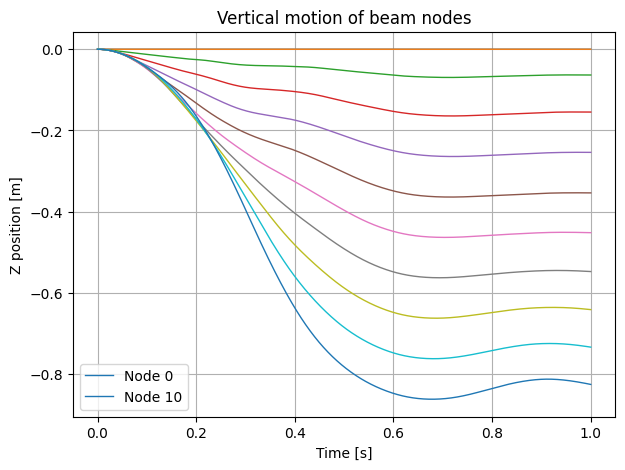

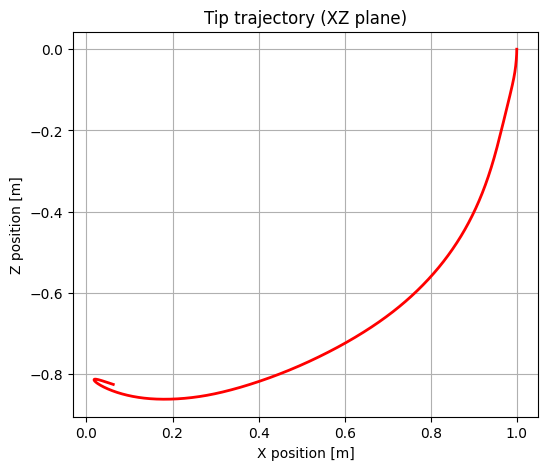

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert trajectory to numpy
q_traj_np = q_traj[:,0:num_nodes*3].detach().numpy().reshape(len(t), num_nodes, 3)

# Plot Z-displacement (vertical motion) of each node
plt.figure(figsize=(7, 5))
for i in range(num_nodes):
    plt.plot(t, q_traj_np[:, i, 2], label=f'Node {i}' if i in [0, num_nodes-1] else "", lw=1)
plt.xlabel("Time [s]")
plt.ylabel("Z position [m]")
plt.title("Vertical motion of beam nodes")
plt.legend()
plt.grid(True)
plt.show()

# Plot trajectory of beam tip (last node)
plt.figure(figsize=(6, 5))
plt.plot(q_traj_np[:, -1, 0], q_traj_np[:, -1, 2], 'r-', lw=2)
plt.xlabel("X position [m]")
plt.ylabel("Z position [m]")
plt.title("Tip trajectory (XZ plane)")
plt.grid(True)
plt.show()


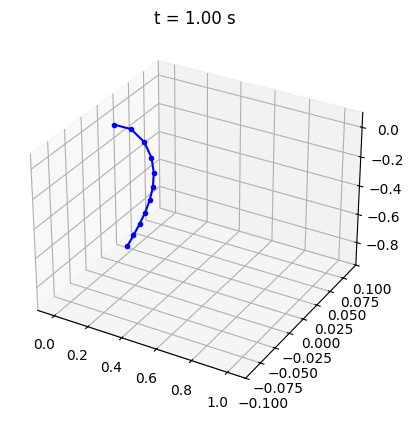

In [13]:
import matplotlib.animation as animation

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.cla()
    ax.plot(q_traj_np[frame, :, 0],
            q_traj_np[frame, :, 1],
            q_traj_np[frame, :, 2],
            'b.-')
    ax.set_xlim([q_traj_np[:, :, 0].min()-0.1, q_traj_np[:, :, 0].max()+0.1])
    ax.set_ylim([q_traj_np[:, :, 1].min()-0.1, q_traj_np[:, :, 1].max()+0.1])
    ax.set_zlim([q_traj_np[:, :, 2].min()-0.1, q_traj_np[:, :, 2].max()+0.1])
    ax.set_title(f"t = {t[frame]:.2f} s")
    return ax

ani = animation.FuncAnimation(fig, update, frames=range(0, len(t), 100), interval=50)
ani.save("beam_motion.gif", writer="ffmpeg", fps=20)
plt.show()
